### **Forecasting Model**

In [3]:
# Commands to Run 
!pip install xgboost

In [4]:
import numpy as np 
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

# Visualization
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import random
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC, LinearSVC
from scipy.optimize import minimize
from sklearn import model_selection 
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate, train_test_split
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
import os

In [5]:
df = pd.read_csv('data/df_web.csv')

In [6]:
df.head()

,Incident Type,Region of Incident,Incident Year,Month,Number of Dead,Total Number of Dead and Missing,Number of Males,Region of Origin,Cause of Death,Country of Incident,...,death,survival_rate,male_to_total_dead_ratio,total_incidents,total_deaths,total_dead_and_missing,year,month,day,dayofweek
0,Incident,North America,2014,January,1.0,1,1.0,Central America,Mixed or unknown,"Arizona, USA",...,30.0,0.0,1.0,212,1071.0,2777,2014,1,1,2
1,Incident,North America,2014,March,1.0,1,1.0,Central America,Harsh environmental conditions / lack of adequ...,"Arizona, USA",...,30.0,0.0,1.0,212,1071.0,2777,2014,1,1,2
2,Incident,Central America,2014,March,1.0,1,1.0,Central America,Vehicle accident / death linked to hazardous t...,Mexico,...,30.0,0.0,1.0,212,1071.0,2777,2014,1,1,2
3,Incident,North America,2014,July,1.0,1,1.0,Central America,Mixed or unknown,"Texas, USA",...,30.0,0.0,1.0,212,1071.0,2777,2014,1,1,2
4,Incident,North America,2014,July,1.0,1,1.0,Central America,Mixed or unknown,"Texas, USA",...,30.0,0.0,1.0,212,1071.0,2777,2014,1,1,2


In [7]:
for col in df.columns:
    print(col)
    print(f"The number of unique values in {col} is {df[col].nunique()}")
    print(f"The data type of {col} is {df[col].dtype}")
    print(f"The number of missing values in {col} is {df[col].isnull().sum()}")

Incident Type
The number of unique values in Incident Type is 3
The data type of Incident Type is object
The number of missing values in Incident Type is 0
Region of Incident
The number of unique values in Region of Incident is 15
The data type of Region of Incident is object
The number of missing values in Region of Incident is 0
Incident Year
The number of unique values in Incident Year is 10
The data type of Incident Year is int64
The number of missing values in Incident Year is 0
Month
The number of unique values in Month is 12
The data type of Month is object
The number of missing values in Month is 0
Number of Dead
The number of unique values in Number of Dead is 63
The data type of Number of Dead is float64
The number of missing values in Number of Dead is 0
Total Number of Dead and Missing
The number of unique values in Total Number of Dead and Missing is 84
The data type of Total Number of Dead and Missing is int64
The number of missing values in Total Number of Dead and Missi

In [9]:
import pandas as pd
from sklearn.impute import KNNImputer

# Create an imputer object
imputer = KNNImputer(n_neighbors=3)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])


In [10]:
start_date = df['Incident Year'].min()
end_date = df['Incident Year'].max()
print(f"The start date of the data is: {start_date}")
print(f"The end date of the data is: {end_date}")

The start date of the data is: 2014.0
The end date of the data is: 2023.0


### Model 1 

Predictions for each month in 2024 with added variation:
2024-01: 3071.00
2024-02: 3071.00
2024-03: 2777.00
2024-04: 3071.00
2024-05: 3071.00
2024-06: 2012.00
2024-07: 3071.00
2024-08: 2012.00
2024-09: 2777.00
2024-10: 2012.00
2024-11: 3071.00
2024-12: 2012.00


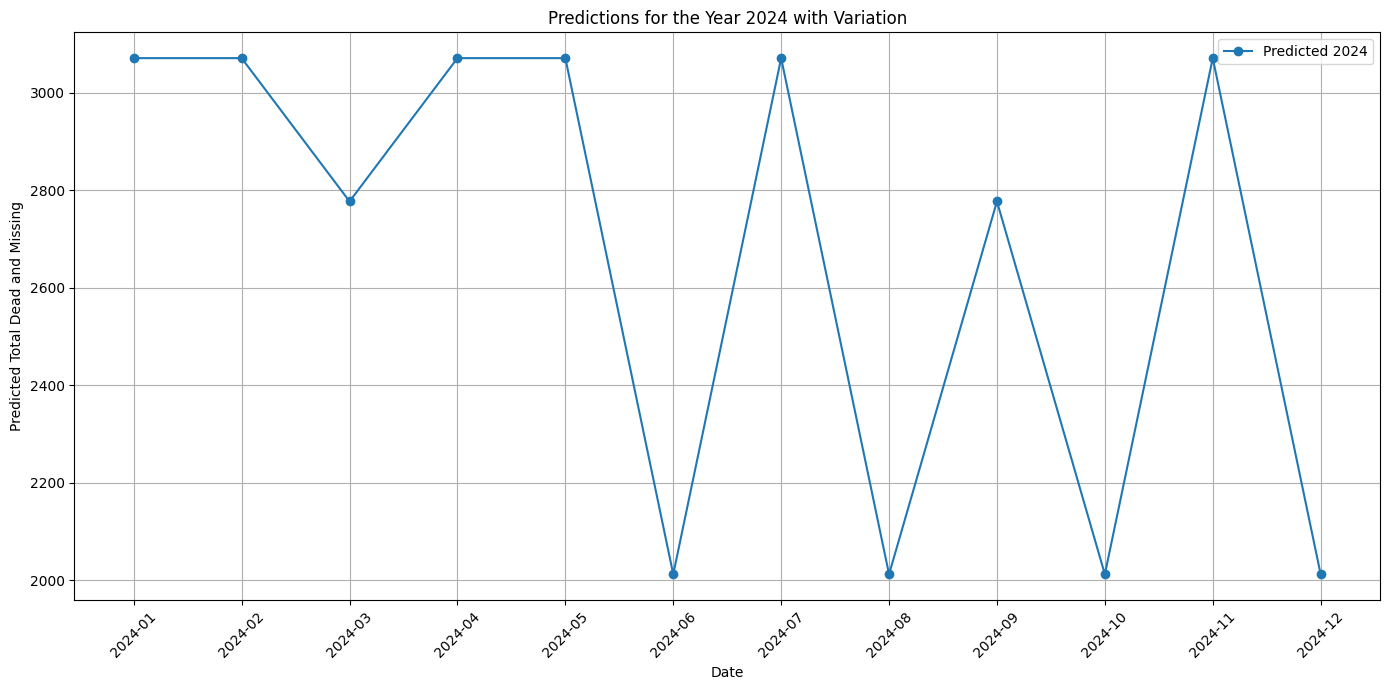

In [14]:
import pandas as pd
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/df_web.csv')

if 'Date' not in df.columns and {'year', 'month', 'day'}.issubset(df.columns):
    df['Date'] = pd.to_datetime(df[['year', 'month', 'day']])
elif 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
else:
    raise ValueError("No appropriate column for 'Date'.")

df.set_index('Date', inplace=True)

# Convert to category
object_cols = df.select_dtypes(include='object').columns
for col in object_cols:
    df[col] = df[col].astype('category')

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Define es and target
target = 'total_dead_and_missing'
features = df.columns.drop(target)

# Split the data
split_date = df.index.max() - pd.Timedelta(days=int(0.1 * len(df)))
train = df[df.index <= split_date]
test = df[df.index > split_date]

# Train the XGBRegressor 
model = XGBRegressor(enable_categorical=True, alpha=0.1, reg_lambda=1.0)
model.fit(train[features], train[target])

# Predictions with randomness for each month in 2024
start_date = pd.Timestamp('2024-01-01')
dates_2024 = pd.date_range(start=start_date, periods=12, freq='MS')

noise_scale = 0.01  
predictions_2024 = {}
for date in dates_2024:
    last_features = train.iloc[-1][features].copy()
    
    # Update the 'year' and 'month' to match the prediction date
    last_features['year'] = date.year
    last_features['month'] = date.month
    
    # Introduce randomness into the numeric features
    for col in numeric_cols:
        if col in last_features and last_features[col] >= 0:
            scale = noise_scale * abs(last_features[col])
            last_features[col] += np.random.normal(0, scale)

    # Convert to DataFrame for prediction
    last_features_df = pd.DataFrame([last_features], index=[date])
    last_features_df[object_cols] = last_features_df[object_cols].apply(lambda x: x.astype('category'))
    
    # Predict and store
    prediction = model.predict(last_features_df[features])[0]
    predictions_2024[date.strftime('%Y-%m')] = prediction

# Print and plot predictions
print("Predictions for each month in 2024 with added variation:")
for date, prediction in predictions_2024.items():
    print(f"{date}: {prediction:.2f}")

plt.figure(figsize=(14, 7))
plt.plot(list(predictions_2024.keys()), list(predictions_2024.values()), marker='o', linestyle='-', label='Predicted 2024')
plt.title('Predictions for the Year 2024 with Variation')
plt.xlabel('Date')
plt.ylabel('Predicted Total Dead and Missing')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Model 2

Predictions for each month in 2024.
2024-01: 2924.00
2024-02: 2777.00
2024-03: 2924.00
2024-04: 2777.00
2024-05: 2924.00
2024-06: 2012.00
2024-07: 2777.00
2024-08: 2012.00
2024-09: 2924.00
2024-10: 2924.00
2024-11: 2777.00
2024-12: 2924.00


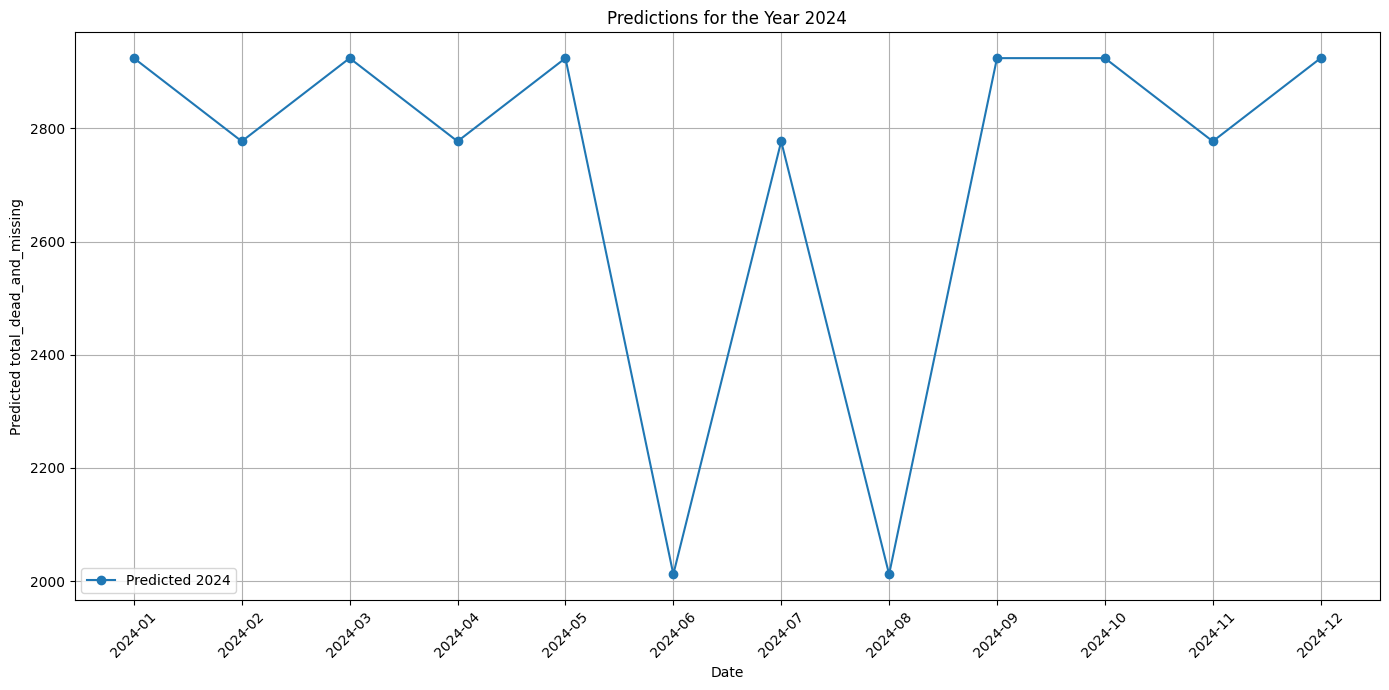

In [15]:
import pandas as pd
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

def predict_future_impacts(data_path, target, features=None, date_columns=None, test_size_days=10, year=2024, noise_scale=0.01):
    # Load the dataset
    df = pd.read_csv(data_path)

    # Date processing
    if 'Date' not in df.columns and {'year', 'month', 'day'}.issubset(df.columns):
        df['Date'] = pd.to_datetime(df[['year', 'month', 'day']])
    elif 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
    else:
        raise ValueError("No appropriate column for 'Date'.")

    df.set_index('Date', inplace=True)

    # Data type conversions
    object_cols = df.select_dtypes(include='object').columns
    for col in object_cols:
        df[col] = df[col].astype('category')

    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    # Define features if not specified
    if features is None:
        features = df.columns.drop(target)

    # Split the data
    split_date = df.index.max() - pd.Timedelta(days=int(test_size_days))
    train = df[df.index <= split_date]
    test = df[df.index > split_date]

    # Train the XGBRegressor
    model = XGBRegressor(enable_categorical=True, alpha=0.1, reg_lambda=1.0)
    model.fit(train[features], train[target])

    # Predictions with randomness for each month in the specified year
    start_date = pd.Timestamp(f'{year}-01-01')
    dates_year = pd.date_range(start=start_date, periods=12, freq='MS')

    predictions_year = {}
    for date in dates_year:
        last_features = train.iloc[-1][features].copy()
        last_features['year'] = date.year
        last_features['month'] = date.month
        for col in numeric_cols:
            if col in last_features and last_features[col] >= 0:
                scale = noise_scale * abs(last_features[col])
                last_features[col] += np.random.normal(0, scale)
        last_features_df = pd.DataFrame([last_features], index=[date])
        last_features_df[object_cols] = last_features_df[object_cols].apply(lambda x: x.astype('category'))
        prediction = model.predict(last_features_df[features])[0]
        predictions_year[date.strftime('%Y-%m')] = prediction

    # Print and plot predictions
    print("Predictions for each month in 2024.")
    for date, prediction in predictions_year.items():
        print(f"{date}: {prediction:.2f}")

    plt.figure(figsize=(14, 7))
    plt.plot(list(predictions_year.keys()), list(predictions_year.values()), marker='o', linestyle='-', label=f'Predicted {year}')
    plt.title(f'Predictions for the Year {year}')
    plt.xlabel('Date')
    plt.ylabel(f'Predicted {target}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example of usage
predict_future_impacts('data/df_web.csv', 'total_dead_and_missing')


### Model 3 

Processing route: Central Mediterranean
Predictions for route Central Mediterranean in 2024 with added variation:
2024-01: 12201.57
2024-02: 12201.57
2024-03: 12201.57
2024-04: 12201.57
2024-05: 12201.57
2024-06: 7909.73
2024-07: 12201.58
2024-08: 7909.74
2024-09: 12201.57
2024-10: 7909.75
2024-11: 7909.73
2024-12: 7909.74
Processing route: Western Balkans
Predictions for route Western Balkans in 2024 with added variation:
2024-01: 2930.25
2024-02: 2930.25
2024-03: 2930.25
2024-04: 2930.25
2024-05: 3052.82
2024-06: 3052.82
2024-07: 2930.25
2024-08: 3052.82
2024-09: 3052.82
2024-10: 2930.25
2024-11: 3052.82
2024-12: 2930.25


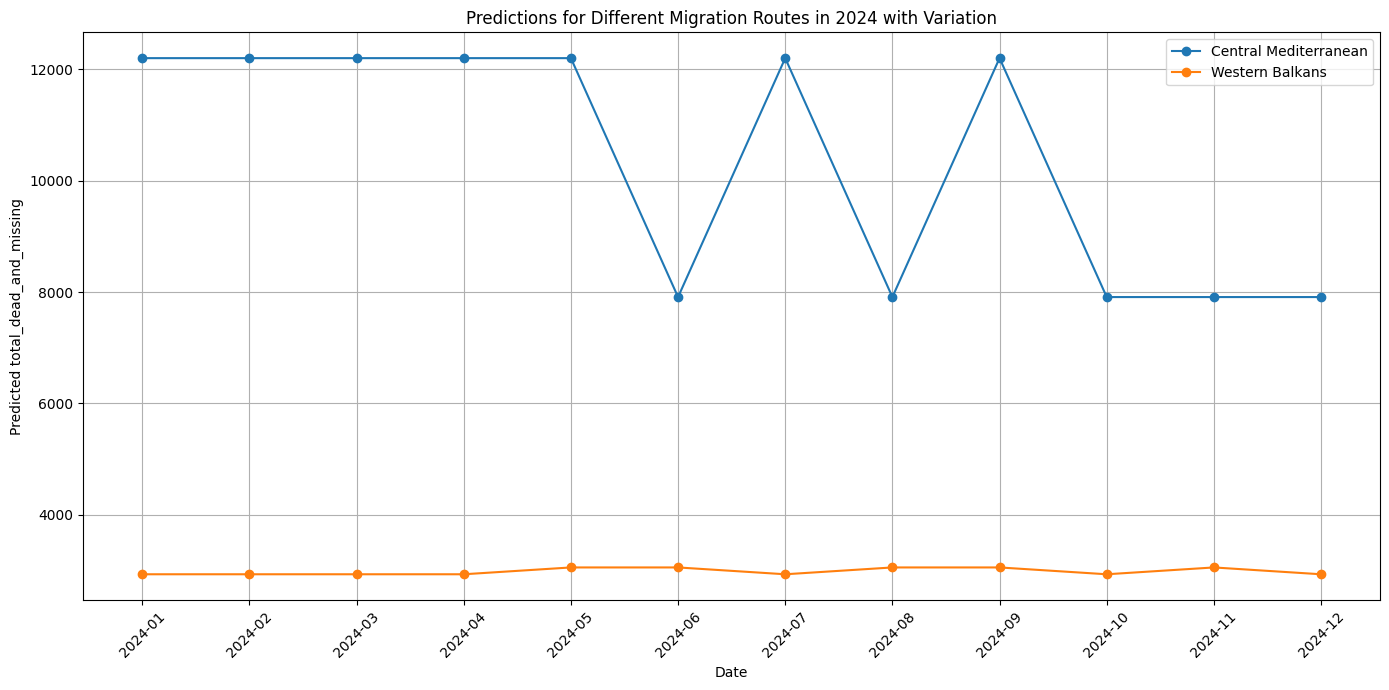

In [19]:
import pandas as pd
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

def predict_future_impacts_by_route(data_path, target, routes, features=None, date_columns=None, test_size_days=10, year=2024, noise_scale=0.01):
    # Load the dataset
    df = pd.read_csv(data_path)

    # Date processing
    if 'Date' not in df.columns and {'year', 'month', 'day'}.issubset(df.columns):
        df['Date'] = pd.to_datetime(df[['year', 'month', 'day']])
    elif 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
    else:
        raise ValueError("No appropriate column for 'Date'.")

    df.set_index('Date', inplace=True)

    # Data type conversions
    object_cols = df.select_dtypes(include='object').columns
    for col in object_cols:
        df[col] = df[col].astype('category')

    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    # Define features if not specified
    if features is None:
        features = df.columns.drop(target)

    # Initialize the results dictionary
    results = {}

    # Process each specified route
    for route in routes:
        print(f"Processing route: {route}")
        route_df = df[df['Migration Route'] == route]
        
        if route_df.empty:
            print(f"No data for route: {route}")
            continue
        
        # Split the data
        split_date = route_df.index.max() - pd.Timedelta(days=int(test_size_days))
        train = route_df[route_df.index <= split_date]
        test = route_df[route_df.index > split_date]

        # Train the XGBRegressor
        model = XGBRegressor(enable_categorical=True, alpha=0.1, reg_lambda=1.0)
        model.fit(train[features], train[target])

        # Predictions with randomness for each month in the specified year
        start_date = pd.Timestamp(f'{year}-01-01')
        dates_year = pd.date_range(start=start_date, periods=12, freq='MS')

        predictions_year = {}
        for date in dates_year:
            last_features = train.iloc[-1][features].copy()
            last_features['year'] = date.year
            last_features['month'] = date.month
            for col in numeric_cols:
                if col in last_features and last_features[col] >= 0:
                    scale = noise_scale * abs(last_features[col])
                    last_features[col] += np.random.normal(0, scale)
            last_features_df = pd.DataFrame([last_features], index=[date])
            last_features_df[object_cols] = last_features_df[object_cols].apply(lambda x: x.astype('category'))
            prediction = model.predict(last_features_df[features])[0]
            predictions_year[date.strftime('%Y-%m')] = prediction

        # Store results for the route
        results[route] = predictions_year
        print(f"Predictions for route {route} in {year}-:")
        for date, prediction in predictions_year.items():
            print(f"{date}: {prediction:.2f}")

    return results

# Example of usage
routes = ['Central Mediterranean', 'Western Balkans']
predictions_by_route = predict_future_impacts_by_route('data/df_web.csv', 'total_dead_and_missing', routes)

# Plotting results for each route
plt.figure(figsize=(14, 7))
for route, predictions in predictions_by_route.items():
    plt.plot(list(predictions.keys()), list(predictions.values()), marker='o', linestyle='-', label=route)
plt.title(f'Predictions for Different Migration Routes in 2024')
plt.xlabel('Date')
plt.ylabel('Predicted total_dead_and_missing')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
